# Пайплайн для выделения лучших кропов по текстовому запросу Yolo -> Clip -> Annoy

Все расчеты ниже получены по **valid** выборке датасета LVIS

* Применяем модель YoloV5L к датасету, получаем кропы для картинок
* Применяем модель clip к каждому кропу, получаем эмбеддинги кропов
* Применяем модель clip к описанию категорий датасета LVIS, получаем эмбеддинги категорий
* Строим индекс annoy по эмбеддингам кропов для поиска ближайших соседей из кропов к каждой категории датасета
* Проводим анализ метрик

В дальнейшем полученный индекс annoy будет использоваться в ДЕМО для поиска подходящих кропов (из valid части датасета LVIS) для текстового запроса пользователя

In [1]:
ANNOY_SIZE = 'BF'
import setproctitle
setproctitle.setproctitle(f"YOLO_{ANNOY_SIZE}")

In [2]:
import sys

sys.path.append("../yolov5")

In [3]:
from assh_utils import Batch, get_iou, load_json, nms

In [4]:
from yolo_utils import CustomWrapper, DetectMultiBackend

In [5]:
import os

root = "/home/asciishell/s3/asciishell-fsod/LVIS/"
js = load_json("/home/asciishell/s3/asciishell-fsod/LVIS/lvis_v1_val.json.zip")
images = [root + x["coco_url"].replace("http://images.cocodataset.org/", "") for x in js["images"]]
assert all([os.path.exists(x) for x in images[:100]])

In [6]:
import itertools
import math
import os
import pickle

import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
from annoy import AnnoyIndex
from sklearn.cluster import KMeans
from sklearn.metrics import average_precision_score
from tqdm.cli import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
%matplotlib inline

cpu


In [7]:
embeddings = np.load("/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid_emb.npy")
images = pd.read_pickle("/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid.done.pkl.zip")

In [8]:
categories_emb = np.load("/home/asciishell/s3/asciishell-fsod/RunYolo/categories_emb.npy")
categories = pd.read_pickle("/home/asciishell/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

In [37]:
def cos_sim_matrix(a, b):
    return np.dot(a, b) / np.linalg.norm(b)

def get_ns_by_vector(vec, n):
    vec = vec.astype(np.float32)
    dist = cos_sim_matrix(embeddings, vec)
    idx = np.argsort(dist)
    top_idx = idx[: -n - 1 : -1]
    return top_idx, dist

## Проводим анализ метрик
Определим, относятся ли в действительности выделенные кропы к заданной категории (с помощью iou) и вычислим метрики качества.

In [44]:
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

In [45]:
metrics = []
annotation = pd.DataFrame(js['annotations'])
for index, category in tqdm(categories.iterrows(), total=categories.shape[0]):
    best = get_ns_by_vector(categories_emb[index], 30) # сколько есть максимально объектов каждой категории:
    x_conf = images.loc[best[0], 'confidence']
    tp = []
    x_iou = []
    for x in best[0]: # имеет ли смысл убрать кропы с одной картинки с большим iou?
        img = images.loc[x]
        for ann in annotation[annotation['image_id'] == int(img['image'][-16:-4])].iterrows():
            ann = ann[1]
            iou = get_iou({'x1': img['xmin'], 'x2': img['xmax'], 'y1': img['ymin'], 'y2': img['ymax']}, 
                    {'x1': ann['bbox'][0], 'x2': ann['bbox'][0] + ann['bbox'][2], 'y1': ann['bbox'][1], 'y2': ann['bbox'][1] + ann['bbox'][3]})
            if iou > 0.5 and ann['category_id'] == category['id']: # стоит ли рассматривать разные iou?
                x_iou.append(iou)
                tp.append(1)
                break
        else:
            x_iou.append(None)
            tp.append(0)
            
    for n_neighb in [1, 5, 10, 20, 30]: 
        metrics.append({
                        'category_id': category['id'], 
                        'category_name': category['name'],
                        'n_neighb': n_neighb,
                        'average_precision_conf': average_precision_score(tp[:n_neighb], x_conf[:n_neighb]),
                        'average_precision_dist': average_precision_score(tp[:n_neighb], 1 / np.array(best[1][:n_neighb])),
                        'average_precision_multi': average_precision_score(tp[:n_neighb], np.array(x_conf[:n_neighb]) / np.array(best[1][:n_neighb])),
                        'tp': np.sum(tp[:n_neighb]),
                        'dist_mean': np.mean(best[1][:n_neighb]), 
                        'conf_mean': np.mean(x_conf[:n_neighb]), 
                        'iou_mean': np.mean([x for x in x_iou[:n_neighb] if x is not None], dtype=np.float64), 
                       })
    # break
metrics = pd.DataFrame(metrics)
metrics.to_pickle(f'/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid_metrics_{ANNOY_SIZE}.pkl.zip')

100%|██████████| 1203/1203 [23:22<00:00,  1.17s/it]


In [51]:
metrics = pd.read_pickle(f"/home/asciishell/s3/asciishell-fsod/RunYoloV2/valid_metrics_{ANNOY_SIZE}.pkl.zip")

In [52]:
metrics["accuracy"] = metrics["tp"] / metrics["n_neighb"]

In [53]:
metrics.head()

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
0,1,aerosol_can,1,NaN,NaN,...,0,0.215813,0.022353,NaN,0.0
1,1,aerosol_can,5,NaN,NaN,...,0,0.204316,0.020082,NaN,0.0
2,1,aerosol_can,10,NaN,NaN,...,0,0.198233,0.096724,NaN,0.0
3,1,aerosol_can,20,NaN,NaN,...,0,0.200447,0.139098,NaN,0.0
4,1,aerosol_can,30,NaN,NaN,...,0,0.197124,0.207596,NaN,0.0


In [54]:
# в топе по accuracy простые и понятные категории (животные, популярные предметы)
metrics_ = metrics[metrics["n_neighb"] == 10]
metrics_.sort_values("accuracy", ascending=False).head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
3057,612,kitten,10,1.00000,1.0,...,10,0.184486,0.342747,0.926084,1.0
287,58,baseball_bat,10,1.00000,1.0,...,10,0.178714,0.298141,0.878371,1.0
2107,422,elephant,10,1.00000,1.0,...,10,0.188680,0.410102,0.888800,1.0
5092,1019,stop_sign,10,1.00000,1.0,...,10,0.149834,0.488265,0.951554,1.0
2842,569,horse,10,1.00000,1.0,...,10,0.191886,0.491670,0.964046,1.0
397,80,cow,10,1.00000,1.0,...,10,0.203693,0.354092,0.889960,1.0
2222,445,fireplug,10,1.00000,1.0,...,10,0.149426,0.483794,0.855491,1.0
1657,332,crow,10,1.00000,1.0,...,10,0.174928,0.290635,0.833773,1.0
1932,387,doughnut,10,1.00000,1.0,...,10,0.214660,0.348220,0.754964,1.0
4807,962,skateboard,10,0.78567,1.0,...,9,0.187871,0.404141,0.906676,0.9


In [55]:
# не угадываем редкие для человека объекты
metrics_.sort_values("accuracy").head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
2,1,aerosol_can,10,NaN,NaN,...,0,0.198233,0.096724,NaN,0.0
3762,753,pancake,10,NaN,NaN,...,0,0.207515,0.239777,NaN,0.0
3767,754,pantyhose,10,NaN,NaN,...,0,0.158786,0.572303,NaN,0.0
3772,755,papaya,10,NaN,NaN,...,0,0.210527,0.467306,NaN,0.0
3777,756,paper_plate,10,NaN,NaN,...,0,0.208631,0.222824,NaN,0.0
3782,757,paper_towel,10,NaN,NaN,...,0,0.184626,0.065420,NaN,0.0
3787,758,paperback_book,10,NaN,NaN,...,0,0.179148,0.186177,NaN,0.0
3792,759,paperweight,10,NaN,NaN,...,0,0.169237,0.188916,NaN,0.0
3797,760,parachute,10,NaN,NaN,...,0,0.189401,0.130050,NaN,0.0
3802,761,parakeet,10,NaN,NaN,...,0,0.190548,0.347088,NaN,0.0


In [56]:
# 1203 * 6 - всего экспериментов
metrics.shape[0]

6015

In [57]:
# у нас много редких категорий
ann = annotation["category_id"].value_counts()
ann

45     9156
127    7022
217    3762
12     3116
827    2724
       ... 
532       1
251       1
619       1
803       1
238       1
Name: category_id, Length: 1035, dtype: int64

In [58]:
# проведем анализ для меньшего числа категорий
len(ann[ann > 100])

327

In [59]:
# общее количество экспериментов
metrics[metrics["category_id"].isin(ann[ann > 100].index)].shape[0]

1635

In [60]:
# общее количество экспериментов с ненулевым tp
q = metrics[(metrics["tp"] != 0) & metrics["category_id"].isin(ann[ann > 100].index)].shape[0]
q, q / 1635

(593, 0.36269113149847093)

In [61]:
# число категорий по которым нет верных ответов
q = metrics[
    (metrics["tp"] == 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
].shape[0]
q, q / 327

(206, 0.6299694189602446)

In [62]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.162080
5     0.743119
10    1.504587
20    2.935780
30    4.311927
Name: tp, dtype: float64

In [63]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.066667
5     0.288889
10    0.538889
20    0.994444
30    1.350000
Name: tp, dtype: float64

In [64]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.162080
5     0.210262
10    0.206193
20    0.194415
30    0.197738
Name: average_precision_conf, dtype: float64

In [65]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.162080
5     0.191633
10    0.195040
20    0.182572
30    0.179885
Name: average_precision_dist, dtype: float64

In [66]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.162080
5     0.204290
10    0.209159
20    0.193422
30    0.192545
Name: average_precision_multi, dtype: float64

In [67]:
len(ann[(ann >= 30) & (ann <= 100)])

180

In [68]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)][
    "average_precision_conf"
].isna().mean()

0.6299694189602446

In [69]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)][
    "average_precision_conf"
].isna().mean()

0.7777777777777778

In [70]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.066667
5     0.094784
10    0.094380
20    0.079396
30    0.069766
Name: average_precision_conf, dtype: float64

In [71]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.066667
5     0.116644
10    0.102584
20    0.091619
30    0.073328
Name: average_precision_dist, dtype: float64

In [72]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.066667
5     0.099506
10    0.091862
20    0.078250
30    0.069220
Name: average_precision_multi, dtype: float64

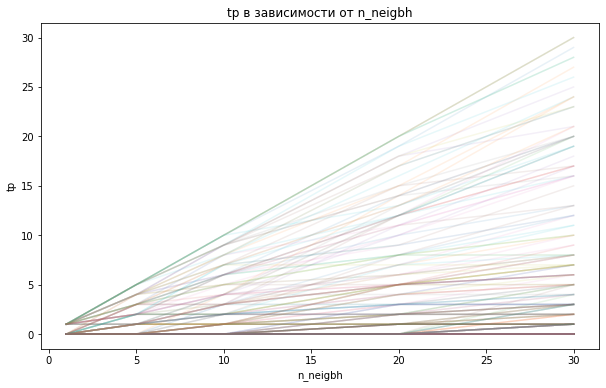

In [73]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["tp"], alpha=0.1)
plt.plot()
plt.title("tp в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("tp")
plt.show()

In [74]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.162080
5     0.148624
10    0.150459
20    0.146789
30    0.143731
Name: accuracy, dtype: float64

In [75]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.066667
5     0.057778
10    0.053889
20    0.049722
30    0.045000
Name: accuracy, dtype: float64

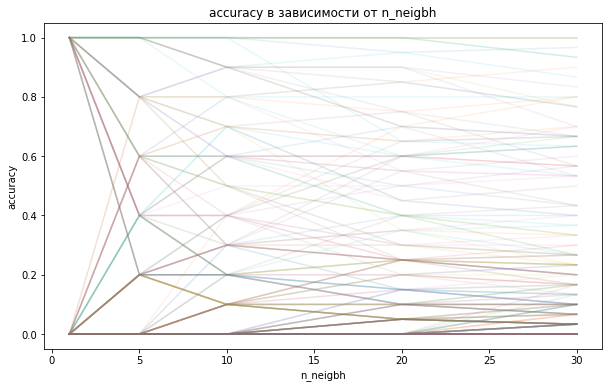

In [76]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["accuracy"], alpha=0.1)
plt.plot()
plt.title("accuracy в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("accuracy")
plt.show()

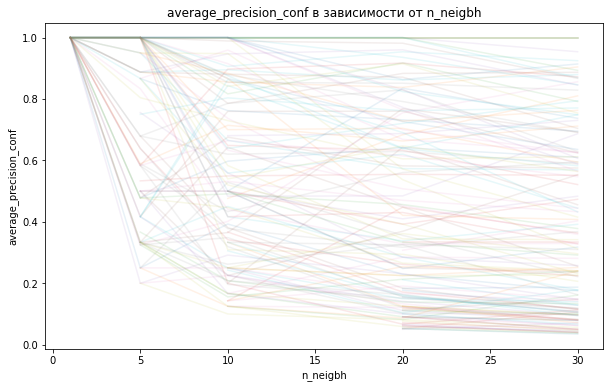

In [77]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_conf"], alpha=0.1)
plt.plot()
plt.title("average_precision_conf в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_conf")
plt.show()

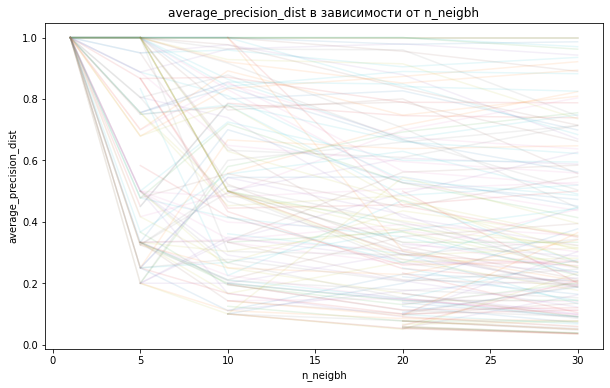

In [78]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_dist"], alpha=0.1)
plt.plot()
plt.title("average_precision_dist в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_dist")
plt.show()

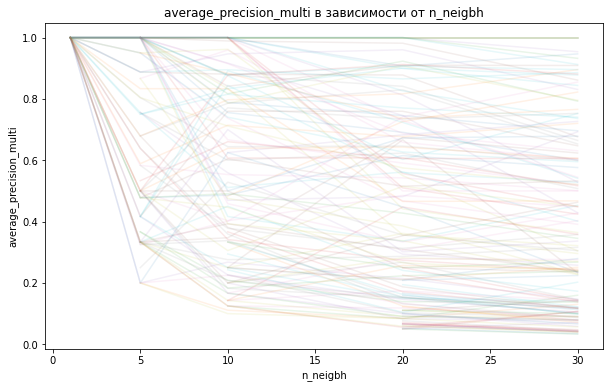

In [79]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_multi"], alpha=0.1)
plt.plot()
plt.title("average_precision_multi в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_multi")
plt.show()

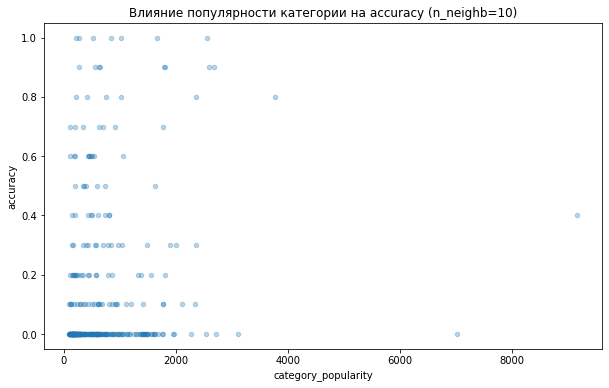

In [80]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на accuracy (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

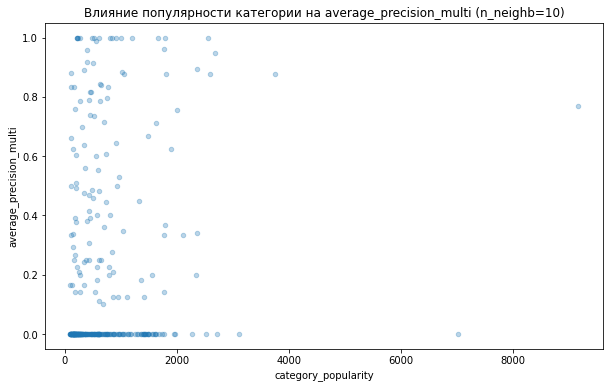

In [81]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

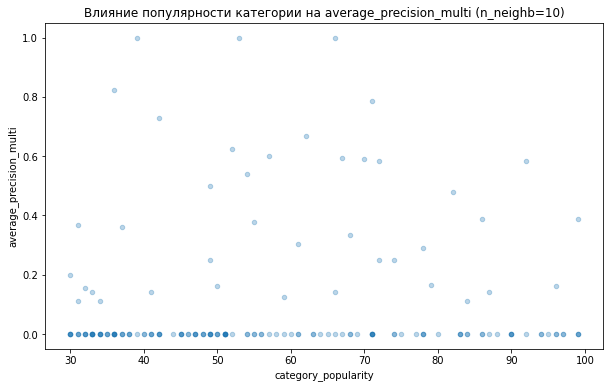

In [82]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

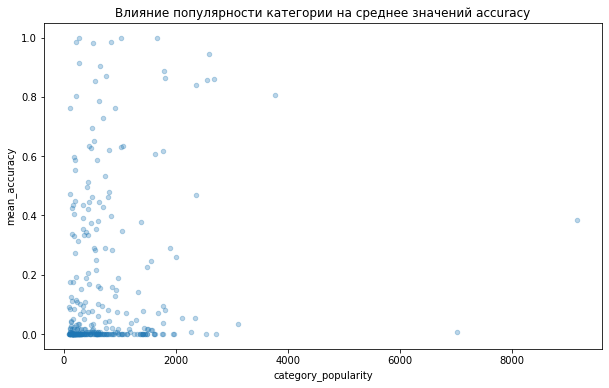

In [83]:
(
    metrics[metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .groupby(["category_id", "category_popularity"])["accuracy"]
    .mean()
    .reset_index(name="mean_accuracy")
    .plot(
        "category_popularity",
        "mean_accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на среднее значений accuracy",
        figsize=(10, 6),
    )
)
plt.show()

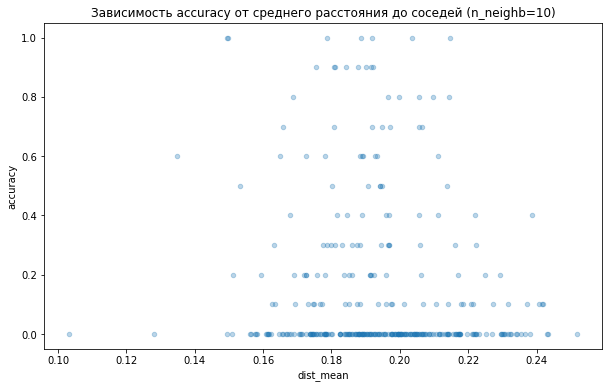

In [84]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "dist_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего расстояния до соседей (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

In [85]:
# top категорий по минимальному расстоянию до соседей (что хорошо знает clip)
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].sort_values("dist_mean").head(
    10
)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,...,tp,dist_mean,conf_mean,iou_mean,accuracy
5772,1155,wall_socket,10,NaN,NaN,...,0,0.103347,0.253400,NaN,0.0
1357,272,clock_tower,10,NaN,NaN,...,0,0.128215,0.321503,NaN,0.0
3827,766,parking_meter,10,0.759722,0.774603,...,6,0.134698,0.313377,0.768982,0.6
5367,1074,telephone_pole,10,NaN,NaN,...,0,0.149363,0.084655,NaN,0.0
2222,445,fireplug,10,1.000000,1.000000,...,10,0.149426,0.483794,0.855491,1.0
5092,1019,stop_sign,10,1.000000,1.000000,...,10,0.149834,0.488265,0.951554,1.0
1302,261,cistern,10,NaN,NaN,...,0,0.150846,0.120319,NaN,0.0
1037,208,railcar_(part_of_a_train),10,0.309524,0.266667,...,2,0.151113,0.348204,0.712345,0.2
5127,1026,street_sign,10,0.729524,0.629524,...,5,0.153159,0.255607,0.829245,0.5
2567,514,green_bean,10,NaN,NaN,...,0,0.156180,0.096485,NaN,0.0


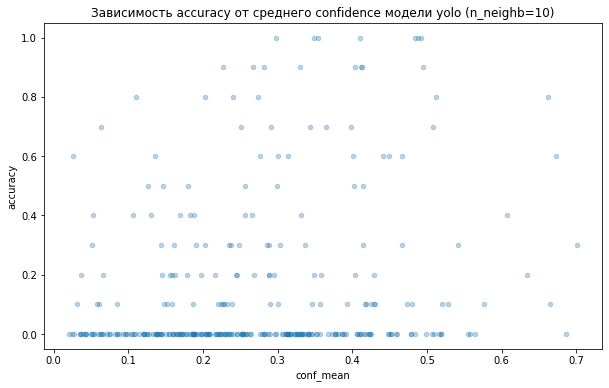

In [86]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

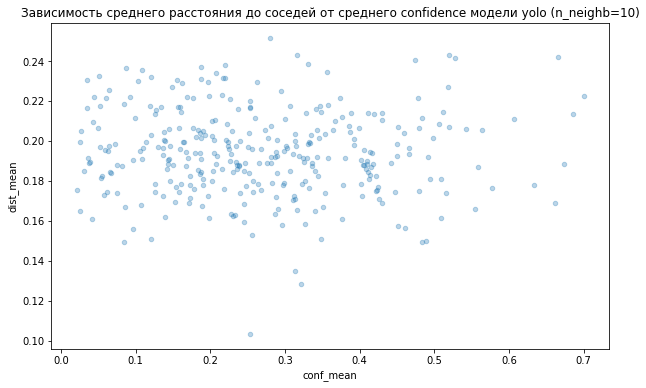

In [87]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "dist_mean",
        kind="scatter",
        alpha=0.3,
        title="Зависимость среднего расстояния до соседей от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

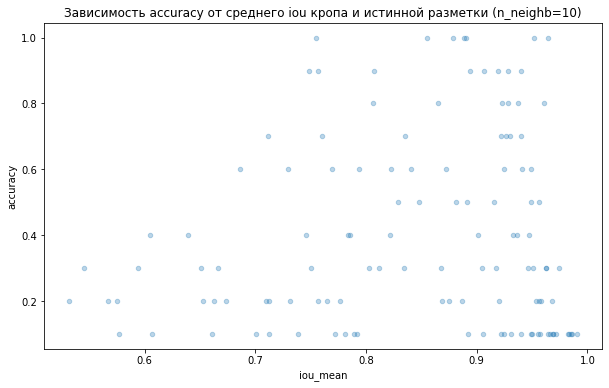

In [88]:
(
    metrics[
        (metrics["tp"] != 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
    ].plot(
        "iou_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего iou кропа и истинной разметки (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()